In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('../combined_reduced.csv')

In [3]:
X1 = np.load('./new_X.npy')

In [4]:
# Convert the DataFrame to a NumPy array
df_array = df.to_numpy()

# Stack the DataFrame and the NumPy array horizontally
X_final = np.hstack((df_array, X1))

In [5]:
combined_df = pd.read_csv('../combined_df.csv')

In [6]:
from sklearn.model_selection import train_test_split

# X = combined_df.drop(['subreddit', 'post'],  axis=1)  # Features
y = combined_df['subreddit']  # Target

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_final  , y, test_size=0.2, random_state=42)

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping 

# Step 1: Encode the categorical target variable (y_train) using OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))

# Step 2: Flatten the encoded labels
y_train_encoded = y_train_encoded.argmax(axis=1)
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1)).argmax(axis=1)
y_train_encoded = to_categorical(y_train_encoded)  # Convert to one-hot encoding


In [9]:

# Define the CNN model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(y_train_encoded.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Reshape X_train to fit the Conv1D input shape
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Train the model
model.fit(X_train_reshaped, y_train_encoded, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

# Evaluate on the test set
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1)).argmax(axis=1)


Epoch 1/10
3745/3745 [==============================] - 38s 10ms/step - loss: 0.9678 - accuracy: 0.6554 - val_loss: 0.8688 - val_accuracy: 0.6858
Epoch 2/10
3745/3745 [==============================] - 37s 10ms/step - loss: 0.8500 - accuracy: 0.6920 - val_loss: 0.8307 - val_accuracy: 0.6993
Epoch 3/10
3745/3745 [==============================] - 37s 10ms/step - loss: 0.8246 - accuracy: 0.7002 - val_loss: 0.8371 - val_accuracy: 0.6937
Epoch 4/10
3745/3745 [==============================] - 41s 11ms/step - loss: 0.8078 - accuracy: 0.7057 - val_loss: 0.8286 - val_accuracy: 0.6995
Epoch 5/10
3745/3745 [==============================] - 58s 15ms/step - loss: 0.7951 - accuracy: 0.7090 - val_loss: 0.8320 - val_accuracy: 0.6985
Epoch 6/10
3745/3745 [==============================] - 55s 15ms/step - loss: 0.7846 - accuracy: 0.7125 - val_loss: 0.8029 - val_accuracy: 0.7078
Epoch 7/10
3745/3745 [==============================] - 49s 13ms/step - loss: 0.7763 - accuracy: 0.7147 - val_loss: 0.8215 -

In [10]:

# Evaluate the model
accuracy = accuracy_score(y_test_encoded, y_pred_classes)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_classes))

Accuracy: 0.7077703604806409
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.68      0.72      1577
           1       0.85      0.86      0.86      9182
           2       0.74      0.77      0.75      1254
           3       0.77      0.80      0.79     11419
           4       0.82      0.73      0.77      1754
           5       0.77      0.59      0.67      4899
           6       0.67      0.66      0.67     23472
           7       0.60      0.65      0.62      4724
           8       0.75      0.64      0.69      1766
           9       0.70      0.63      0.66      1788
          10       0.62      0.69      0.65     13065

    accuracy                           0.71     74900
   macro avg       0.73      0.70      0.71     74900
weighted avg       0.71      0.71      0.71     74900



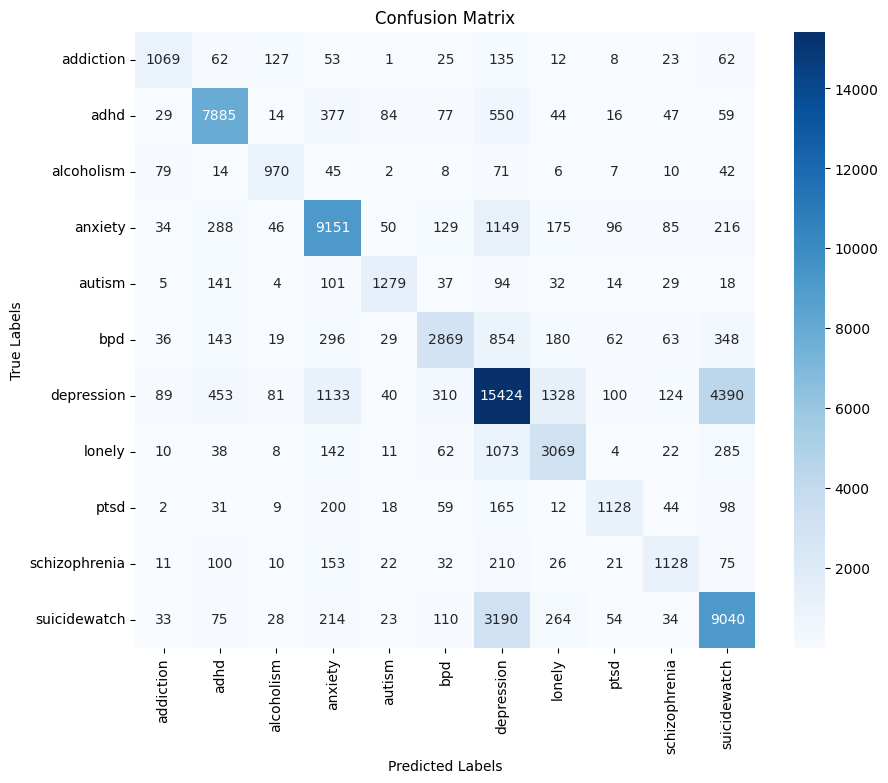

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you already have predictions in y_pred_classes and the true labels in y_test_encoded

# Compute confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred_classes)

# Display the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
